In [2]:
# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps
from matplotlib import colors
import matplotlib.path as mpath

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num

import gsw


In [64]:
# read grid file for lon/lat coordinates
dg = xr.open_dataset("/scratch/project_2000339/boeiradi/waom10_frc/waom10extend_grd.nc")
lat_rho_10km= dg.variables["lat_rho"]
lon_rho_10km = dg.variables["lon_rho"]
cor = dg.variables["f"]
pm = dg.variables["pm"]
pn = dg.variables["pn"]
dndx = dg.variables["dndx"]
dmde = dg.variables["dmde"]
dg.close()

In [129]:

# load ROMS avg output

def read_roms_ts_10km(exp_path):
    for yr  in ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20']:
        ds = xr.open_dataset(exp_path + 'ocean_avg_00' + yr + '.nc')
        print('size temp and time length: ', ds.temp.shape, len(ds.salt.isel(xi_rho=20, eta_rho=100, s_rho=0)))
        temp_tmp = ds.variables["temp"]
        salt_tmp = ds.variables["salt"]
        zeta_tmp = ds.variables["zeta"]
        temp_tmp_ann = np.nanmean(temp_tmp, axis=0)
        salt_tmp_ann = np.nanmean(salt_tmp, axis=0)
        print('size temp_tmp_ann = ', temp_tmp_ann.shape)

        # calculate geostrophic velocities from ssh:
        g = 9.81
        dzetady = np.diff(zeta_tmp, axis=1)
        dzetadx = np.diff(zeta_tmp, axis=2)
        mmax = 12
        dzeta_dy = np.empty((dzetady[:,:,0:-1].shape))
        dzeta_dx = np.empty((dzetadx[:,0:-1,:].shape))
        for mm in np.arange(0,mmax,1):
            dzeta_dy[mm,:,:] = dzetady[mm,:,0:-1]*pn[0:-1,0:-1]
            dzeta_dx[mm,:,:]= dzetadx[mm,0:-1,:]*pm[0:-1,0:-1]

        ugeo = np.empty((dzeta_dy.shape))
        vgeo = np.empty((dzeta_dx.shape))
        for mm in np.arange(0,mmax,1):
            ugeo[mm,:,:] = -(g/cor[0:-1,0:-1])*dzeta_dy[mm,:,:]
            vgeo[mm,:,:] = (g/cor[0:-1,0:-1])*dzeta_dx[mm,:,:]
        ugeo_ann_tmp = np.nanmean(ugeo, axis=0)
        vgeo_ann_tmp = np.nanmean(vgeo, axis=0)
        V_ann_tmp = np.sqrt(ugeo_ann_tmp*ugeo_ann_tmp + vgeo_ann_tmp*vgeo_ann_tmp)
        MKE_tmp = np.divide(V_ann_tmp*V_ann_tmp,2)
        print("Size MKE_tmp", MKE_tmp.shape)
        
        ugeo_anom_tmp = ugeo - ugeo_ann_tmp
        vgeo_anom_tmp = vgeo - vgeo_ann_tmp
        V_anom_tmp = np.sqrt(ugeo_anom_tmp*ugeo_anom_tmp + vgeo_anom_tmp*vgeo_anom_tmp)
        V_anom_ann = np.nanmean(V_anom_tmp, axis=0)
        EKE_tmp = np.divide(V_anom_ann*V_anom_ann,2)
        print("Size EKE_tmp", EKE_tmp.shape)

        ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

        if ds.Vtransform == 1:
            Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
            z_rho_tmp = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
            print("Vtransform=1")
        elif ds.Vtransform == 2:
            Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
            z_rho_tmp = ds.zeta + (ds.zeta + ds.h) * Zo_rho
            print("Vtransform=2")
        z_rho_tmp_ann = np.nanmean(z_rho_tmp, axis=0)

        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w_tmp = ds.zeta + (ds.zeta + ds.h) * Zo_w
        z_w_tmp_ann = np.nanmean(z_w_tmp, axis=0)

        # concantenate annual averaged temp/salt
        if yr == '01':
            temp_ann = temp_tmp_ann
            salt_ann = salt_tmp_ann
            z_w_ann = z_w_tmp_ann
            z_rho_ann = z_rho_tmp_ann
            MKE = MKE_tmp
            EKE = EKE_tmp
        elif yr == '02':
            temp_ann = np.stack((temp_ann,temp_tmp_ann), axis=0)
            salt_ann = np.stack((salt_ann,salt_tmp_ann), axis=0)
            z_w_ann = np.stack((z_w_ann,z_w_tmp_ann), axis=0)
            z_rho_ann = np.stack((z_rho_ann,z_rho_tmp_ann), axis=0)
            MKE = np.stack((MKE,MKE_tmp), axis=0)
            EKE = np.stack((EKE,EKE_tmp), axis=0)
        else:
            temp_tmp_ann_4thdim = np.expand_dims(temp_tmp_ann, axis=0)
            temp_ann = np.concatenate((temp_ann,temp_tmp_ann_4thdim), axis=0)
            salt_tmp_ann_4thdim = np.expand_dims(salt_tmp_ann, axis=0)
            salt_ann = np.concatenate((salt_ann,salt_tmp_ann_4thdim), axis=0)
            z_w_tmp_ann_4thdim = np.expand_dims(z_w_tmp_ann, axis=0)
            z_w_ann = np.concatenate((z_w_ann,z_w_tmp_ann_4thdim), axis=0)
            z_rho_tmp_ann_4thdim = np.expand_dims(z_rho_tmp_ann, axis=0)
            z_rho_ann = np.concatenate((z_rho_ann,z_rho_tmp_ann_4thdim), axis=0)
            MKE_tmp_4thdim = np.expand_dims(MKE_tmp, axis=0)
            MKE = np.concatenate((MKE,MKE_tmp_4thdim), axis=0)
            EKE_tmp_4thdim = np.expand_dims(EKE_tmp, axis=0)
            EKE = np.concatenate((EKE,EKE_tmp_4thdim), axis=0)
            del temp_tmp_ann_4thdim, salt_tmp_ann_4thdim, z_w_tmp_ann_4thdim, z_rho_tmp_ann_4thdim, MKE_tmp_4thdim, EKE_tmp_4thdim

        print('Annual temp and annual tmp temp sizes = ', temp_ann.shape, temp_tmp_ann.shape)
        print('Annual z_w and annual tmp z_w sizes = ', z_w_ann.shape, z_w_tmp_ann.shape)

        del temp_tmp_ann, salt_tmp_ann, z_w_tmp_ann, z_rho_tmp_ann

    print('Annual temp, salt, z_w, z_rho, MKE sizes = ', temp_ann.shape, salt_ann.shape, z_w_ann.shape, z_rho_ann.shape, MKE.shape)

    # shelf/open-ocean masks:
    mask_shelf = np.empty((ds.h.shape))
    shelf_ind=ds.h.where(ds.h < 2000)
    #print(open_ind)

    mask_shelf = np.divide(shelf_ind,shelf_ind)

    # calculate dz following:
    dz = np.empty((20,560,630,31))
    dz_inv = np.empty((20,560,630,31))

    for tt in np.arange(0,20):
        z_w_sorted = -1*z_w_ann[tt,:,::-1]
        #print(z_w_sorted.shape)
        dz_inv[tt,:,:,:] = np.diff(z_w_sorted,axis=2)
        dz[tt,:,:,:] = dz_inv[tt,:,:,::-1]

    print('size dz = ', dz.shape)

    # first, vertical integral:
    ohc_dz = np.empty((20,31,560,630))
    salt_dz = np.empty((20,31,560,630))

    cp_rho = 3989.245*1035 # J/kg/degC
    ohc_ann = cp_rho*temp_ann

    for tt in np.arange(0,20):
        for zz in np.arange(30,-1,-1):
            ohc_dz[tt,zz,:,:] = ohc_ann[tt,zz,:,:]*dz[tt,:,:,zz]
            salt_dz[tt,zz,:,:] = salt_ann[tt,zz,:,:]*dz[tt,:,:,zz]

    ohc_vertint = np.nansum(ohc_dz[:,::-1,:,:], axis=1)
    salt_vertint = np.nansum(salt_dz[:,::-1,:,:], axis=1)
    print('size ohc_ann, ohc_dz, ohc_vertint = ', ohc_ann.shape, ohc_dz.shape, ohc_vertint.shape)

    # horizontal integral
    p_area = ds.pm.isel(eta_rho=slice(0,560), xi_rho=slice(0,630))*ds.pn.isel(eta_rho=slice(0,560), xi_rho=slice(0,630))
    area = 1/p_area # area in meters

    print('size area = ', area.shape)

    ohc_area_shelf = np.empty((20,560,630))
    salt_area_shelf = np.empty((20,560,630))
    ohc_hint_shelf = np.empty((20,))
    salt_hint_shelf = np.empty((20,))
    ohc_hintn_shelf = np.empty((20,))
    salt_hintn_shelf = np.empty((20,))

    for tt in np.arange(0,20,1):
        ohc_area_shelf[tt,:,:] = ohc_vertint[tt,:,:]*area*mask_shelf
        salt_area_shelf[tt,:,:] =salt_vertint[tt,:,:]*area*mask_shelf
        ohc_hint_shelf[tt] = np.nansum(np.nansum((ohc_area_shelf[tt,:,:]), axis=1),axis=0)
        salt_hint_shelf[tt] = np.nansum(np.nansum((salt_area_shelf[tt,:,:]), axis=1),axis=0)
        area_sum_shelf = np.nansum(np.nansum(area*mask_shelf, axis=1),axis=0)

        ohc_hintn_shelf[tt] = np.divide(ohc_hint_shelf[tt],area_sum_shelf)
        salt_hintn_shelf[tt] = np.divide(salt_hint_shelf[tt],area_sum_shelf)

    MKE_havg_shelf = np.empty((20,))
    SST_havg_shelf = np.empty((20,))
    SSS_havg_shelf = np.empty((20,))

    for tt in np.arange(0,20,1):
        MKE_havg_shelf[tt] = np.nanmean(np.nanmean((MKE[tt,:,:]), axis=1),axis=0)
        SST_havg_shelf[tt] = np.nanmean(np.nanmean((temp_ann[tt,-1,:,:]*mask_shelf), axis=1),axis=0)
        SSS_havg_shelf[tt] = np.nanmean(np.nanmean((salt_ann[tt,-1,:,:]*mask_shelf), axis=1),axis=0)


    return SST_havg_shelf, SSS_havg_shelf, ohc_hintn_shelf, salt_hintn_shelf, MKE_havg_shelf, MKE, EKE

In [130]:
path_ECCO2_10km = '/scratch/project_2000789/boeiradi/waom10extend_shflim_S_0.25Q/output_01-20yr/'

E10_SST_havg_shelf, E10_SSS_havg_shelf, E10_ohc_hintn_shelf, E10_salt_hintn_shelf, E10_MKE_havg_shelf, MKE, EKE = read_roms_ts_10km(path_ECCO2_10km)

size temp and time length:  (12, 31, 560, 630) 12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


size temp_tmp_ann =  (31, 560, 630)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


Size MKE_tmp (559, 629)
Size EKE_tmp (559, 629)
Vtransform=2


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


Annual temp and annual tmp temp sizes =  (31, 560, 630) (31, 560, 630)
Annual z_w and annual tmp z_w sizes =  (560, 630, 32) (560, 630, 32)
size temp and time length:  (12, 31, 560, 630) 12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


size temp_tmp_ann =  (31, 560, 630)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


Size MKE_tmp (559, 629)
Size EKE_tmp (559, 629)
Vtransform=2


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


Annual temp and annual tmp temp sizes =  (2, 31, 560, 630) (31, 560, 630)
Annual z_w and annual tmp z_w sizes =  (2, 560, 630, 32) (560, 630, 32)
size temp and time length:  (12, 31, 560, 630) 12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


size temp_tmp_ann =  (31, 560, 630)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


Size MKE_tmp (559, 629)
Size EKE_tmp (559, 629)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


Vtransform=2


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


Annual temp and annual tmp temp sizes =  (3, 31, 560, 630) (31, 560, 630)
Annual z_w and annual tmp z_w sizes =  (3, 560, 630, 32) (560, 630, 32)
size temp and time length:  (12, 31, 560, 630) 12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


size temp_tmp_ann =  (31, 560, 630)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


Size MKE_tmp (559, 629)
Size EKE_tmp (559, 629)
Vtransform=2


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


Annual temp and annual tmp temp sizes =  (4, 31, 560, 630) (31, 560, 630)
Annual z_w and annual tmp z_w sizes =  (4, 560, 630, 32) (560, 630, 32)
size temp and time length:  (12, 31, 560, 630) 12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


size temp_tmp_ann =  (31, 560, 630)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


Size MKE_tmp (559, 629)
Size EKE_tmp (559, 629)
Vtransform=2


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


Annual temp and annual tmp temp sizes =  (5, 31, 560, 630) (31, 560, 630)
Annual z_w and annual tmp z_w sizes =  (5, 560, 630, 32) (560, 630, 32)
size temp and time length:  (12, 31, 560, 630) 12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


size temp_tmp_ann =  (31, 560, 630)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


Size MKE_tmp (559, 629)
Size EKE_tmp (559, 629)
Vtransform=2


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


Annual temp and annual tmp temp sizes =  (6, 31, 560, 630) (31, 560, 630)
Annual z_w and annual tmp z_w sizes =  (6, 560, 630, 32) (560, 630, 32)
size temp and time length:  (12, 31, 560, 630) 12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


size temp_tmp_ann =  (31, 560, 630)
Size MKE_tmp (559, 629)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


Size EKE_tmp (559, 629)
Vtransform=2


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


Annual temp and annual tmp temp sizes =  (7, 31, 560, 630) (31, 560, 630)
Annual z_w and annual tmp z_w sizes =  (7, 560, 630, 32) (560, 630, 32)
size temp and time length:  (12, 31, 560, 630) 12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


size temp_tmp_ann =  (31, 560, 630)
Size MKE_tmp (559, 629)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


Size EKE_tmp (559, 629)
Vtransform=2


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


Annual temp and annual tmp temp sizes =  (8, 31, 560, 630) (31, 560, 630)
Annual z_w and annual tmp z_w sizes =  (8, 560, 630, 32) (560, 630, 32)
size temp and time length:  (12, 31, 560, 630) 12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


size temp_tmp_ann =  (31, 560, 630)
Size MKE_tmp (559, 629)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


Size EKE_tmp (559, 629)
Vtransform=2


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


Annual temp and annual tmp temp sizes =  (9, 31, 560, 630) (31, 560, 630)
Annual z_w and annual tmp z_w sizes =  (9, 560, 630, 32) (560, 630, 32)
size temp and time length:  (12, 31, 560, 630) 12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


size temp_tmp_ann =  (31, 560, 630)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


Size MKE_tmp (559, 629)
Size EKE_tmp (559, 629)
Vtransform=2


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


Annual temp and annual tmp temp sizes =  (10, 31, 560, 630) (31, 560, 630)
Annual z_w and annual tmp z_w sizes =  (10, 560, 630, 32) (560, 630, 32)
size temp and time length:  (12, 31, 560, 630) 12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


size temp_tmp_ann =  (31, 560, 630)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


Size MKE_tmp (559, 629)
Size EKE_tmp (559, 629)
Vtransform=2


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


Annual temp and annual tmp temp sizes =  (11, 31, 560, 630) (31, 560, 630)
Annual z_w and annual tmp z_w sizes =  (11, 560, 630, 32) (560, 630, 32)
size temp and time length:  (12, 31, 560, 630) 12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


size temp_tmp_ann =  (31, 560, 630)
Size MKE_tmp (559, 629)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


Size EKE_tmp (559, 629)
Vtransform=2


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


Annual temp and annual tmp temp sizes =  (12, 31, 560, 630) (31, 560, 630)
Annual z_w and annual tmp z_w sizes =  (12, 560, 630, 32) (560, 630, 32)
size temp and time length:  (12, 31, 560, 630) 12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


size temp_tmp_ann =  (31, 560, 630)
Size MKE_tmp (559, 629)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


Size EKE_tmp (559, 629)
Vtransform=2


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


Annual temp and annual tmp temp sizes =  (13, 31, 560, 630) (31, 560, 630)
Annual z_w and annual tmp z_w sizes =  (13, 560, 630, 32) (560, 630, 32)
size temp and time length:  (12, 31, 560, 630) 12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


size temp_tmp_ann =  (31, 560, 630)
Size MKE_tmp (559, 629)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


Size EKE_tmp (559, 629)
Vtransform=2


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


Annual temp and annual tmp temp sizes =  (14, 31, 560, 630) (31, 560, 630)
Annual z_w and annual tmp z_w sizes =  (14, 560, 630, 32) (560, 630, 32)
size temp and time length:  (12, 31, 560, 630) 12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


size temp_tmp_ann =  (31, 560, 630)
Size MKE_tmp (559, 629)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


Size EKE_tmp (559, 629)
Vtransform=2


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


Annual temp and annual tmp temp sizes =  (15, 31, 560, 630) (31, 560, 630)
Annual z_w and annual tmp z_w sizes =  (15, 560, 630, 32) (560, 630, 32)
size temp and time length:  (12, 31, 560, 630) 12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


size temp_tmp_ann =  (31, 560, 630)
Size MKE_tmp (559, 629)
Size EKE_tmp (559, 629)
Vtransform=2


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


Annual temp and annual tmp temp sizes =  (16, 31, 560, 630) (31, 560, 630)
Annual z_w and annual tmp z_w sizes =  (16, 560, 630, 32) (560, 630, 32)
size temp and time length:  (12, 31, 560, 630) 12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


size temp_tmp_ann =  (31, 560, 630)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


Size MKE_tmp (559, 629)
Size EKE_tmp (559, 629)
Vtransform=2


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


Annual temp and annual tmp temp sizes =  (17, 31, 560, 630) (31, 560, 630)
Annual z_w and annual tmp z_w sizes =  (17, 560, 630, 32) (560, 630, 32)
size temp and time length:  (12, 31, 560, 630) 12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


size temp_tmp_ann =  (31, 560, 630)
Size MKE_tmp (559, 629)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


Size EKE_tmp (559, 629)
Vtransform=2


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


Annual temp and annual tmp temp sizes =  (18, 31, 560, 630) (31, 560, 630)
Annual z_w and annual tmp z_w sizes =  (18, 560, 630, 32) (560, 630, 32)
size temp and time length:  (12, 31, 560, 630) 12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


size temp_tmp_ann =  (31, 560, 630)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


Size MKE_tmp (559, 629)
Size EKE_tmp (559, 629)
Vtransform=2


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


Annual temp and annual tmp temp sizes =  (19, 31, 560, 630) (31, 560, 630)
Annual z_w and annual tmp z_w sizes =  (19, 560, 630, 32) (560, 630, 32)
size temp and time length:  (12, 31, 560, 630) 12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


size temp_tmp_ann =  (31, 560, 630)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


Size MKE_tmp (559, 629)
Size EKE_tmp (559, 629)
Vtransform=2


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


Annual temp and annual tmp temp sizes =  (20, 31, 560, 630) (31, 560, 630)
Annual z_w and annual tmp z_w sizes =  (20, 560, 630, 32) (560, 630, 32)
Annual temp, salt, z_w, z_rho, MKE sizes =  (20, 31, 560, 630) (20, 31, 560, 630) (20, 560, 630, 32) (20, 560, 630, 31) (20, 559, 629)
size dz =  (20, 560, 630, 31)
size ohc_ann, ohc_dz, ohc_vertint =  (20, 31, 560, 630) (20, 31, 560, 630) (20, 560, 630)
size area =  (560, 630)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:160: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:161: RuntimeWarning: Mean of empty slice


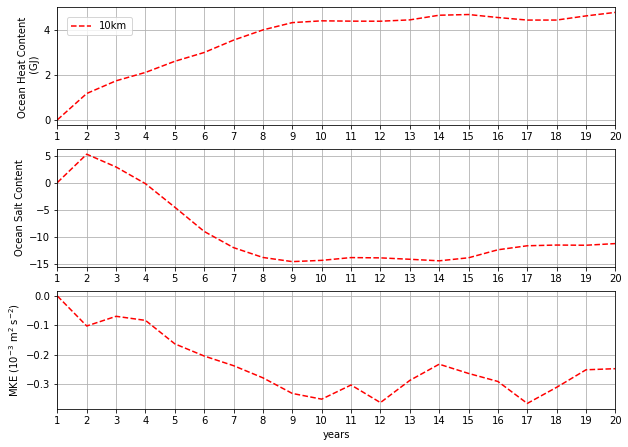

In [96]:
fig_path='/users/boeiradi/COLD_project/postprocessing/figs/Grid_avg/'

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(411)
plt.plot(np.arange(0,20)+1,(E10_ohc_hintn_shelf - E10_ohc_hintn_shelf[0])*1e-8,'--r',label='10km')
# plt.plot(np.arange(10,20)+1,(E4_ohc_hintn_shelf - E4_ohc_hintn_shelf[0])*1e-8,'--b',label='4km')
# plt.plot(np.arange(15,20)+1,(E2_ohc_hintn_shelf - E2_ohc_hintn_shelf[0])*1e-8,'--g',label='2km')
l1 = plt.legend(loc='upper left', borderaxespad=1)
plt.ylabel('Ocean Heat Content \n (GJ)')
plt.grid('on')
plt.xticks(np.arange(0, 21, step=1)),plt.xlim([1,20])
ax2 = fig.add_subplot(412)
plt.plot(np.arange(0,20)+1,-E10_salt_hintn_shelf + E10_salt_hintn_shelf[0],'--r',label='10km')
# plt.plot(np.arange(10,20)+1,-E4_salt_hintn_shelf + E4_salt_hintn_shelf[0],'--b',label='4km')
# plt.plot(np.arange(15,20)+1,-E2_salt_hintn_shelf + E2_salt_hintn_shelf[0],'--g',label='2km')
plt.ylabel('Ocean Salt Content')
plt.xticks(np.arange(0, 21, step=1)),plt.xlim([1,20])
plt.grid('on')
ax3 = fig.add_subplot(413)
plt.ylabel('MKE (10$^{-3}$ m$^{2}$ s$^{-2}$)')
plt.plot(np.arange(0,20)+1,(E10_MKE_havg_shelf - E10_MKE_havg_shelf[0])*1e3,'--r',label='10km')
# plt.plot(np.arange(10,20)+1,(E4_MKE_havg_shelf - E4_MKE_havg_shelf[0])*1e3,'--b',label='4km')
# plt.plot(np.arange(15,20)+1,(E2_MKE_havg_shelf - E2_MKE_havg_shelf[0])*1e3,'--g',label='2km')
plt.xlabel('years')
plt.grid('on')
plt.xticks(np.arange(0, 21, step=1)),plt.xlim([1,20])

name_fig="waom10extend_shflim_S_0.25Q_OHC+Salt+SST+SSS+MKE_anom_evolution_shelf.png"
plt.savefig(fig_path + name_fig, dpi=300)
# plt.close()
plt.show()

(20, 559, 629) (20, 559, 629)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


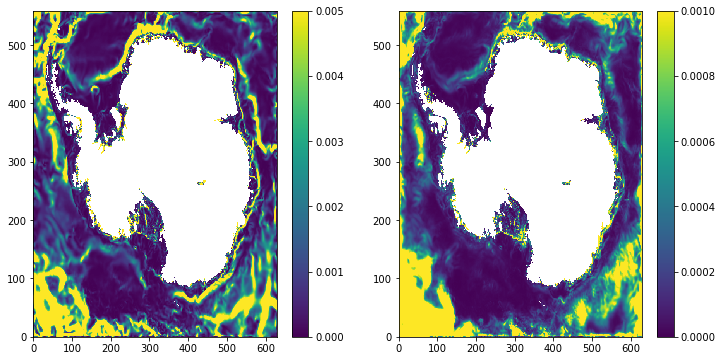

In [141]:
# plots MKE x EKE

print(MKE.shape, EKE.shape)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
plt.pcolormesh(np.nanmean(MKE, axis=0))
plt.colorbar()
plt.clim([0,0.005])
ax2 = fig.add_subplot(122)
plt.pcolormesh(np.nanmean(EKE, axis=0))
plt.colorbar()
plt.clim([0,0.001])

plt.show()

In [ ]:
# ==========================

In [97]:
# check MKE values


# load ROMS avg output

def read_roms_ts_10km(exp_path):
    for yr  in ['01','02']:#,'03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20']:
        ds = xr.open_dataset(exp_path + 'ocean_avg_00' + yr + '.nc')
        print('size temp and time length: ', ds.temp.shape, len(ds.salt.isel(xi_rho=20, eta_rho=100, s_rho=0)))
        temp_tmp = ds.variables["temp"]
        salt_tmp = ds.variables["salt"]
        zeta_tmp = ds.variables["zeta"]
        temp_tmp_ann = np.nanmean(temp_tmp, axis=0)
        salt_tmp_ann = np.nanmean(salt_tmp, axis=0)
        print('size temp_tmp_ann = ', temp_tmp_ann.shape)
        print(len(zeta_tmp))

        # calculate geostrophic velocities from ssh:
        g = 9.81
        dzetady = np.diff(zeta_tmp, axis=1)
        dzetadx = np.diff(zeta_tmp, axis=2)
        mmax = 12
        dzeta_dy = np.empty((dzetady[:,:,0:-1].shape))
        dzeta_dx = np.empty((dzetadx[:,0:-1,:].shape))
        for mm in np.arange(0,mmax,1):
            dzeta_dy[mm,:,:] = dzetady[mm,:,0:-1]*pn[0:-1,0:-1]
            dzeta_dx[mm,:,:]= dzetadx[mm,0:-1,:]*pm[0:-1,0:-1]

        ugeo = np.empty((dzeta_dy.shape))
        vgeo = np.empty((dzeta_dx.shape))
        for mm in np.arange(0,mmax,1):
            ugeo[mm,:,:] = -(g/cor[0:-1,0:-1])*dzeta_dy[mm,:,:]
            vgeo[mm,:,:] = (g/cor[0:-1,0:-1])*dzeta_dx[mm,:,:]
        ugeo_ann_tmp = np.nanmean(ugeo, axis=0)
        vgeo_ann_tmp = np.nanmean(vgeo, axis=0)
        #ugeo_anom_tmp = ugeo - ugeo_ann
        #vgeo_anom_tmp = vgeo - vgeo_ann
        V_ann_tmp = np.sqrt(ugeo_ann_tmp*ugeo_ann_tmp + vgeo_ann_tmp*vgeo_ann_tmp)
        MKE_tmp = np.divide(V_ann_tmp*V_ann_tmp,2)
        print("Size MKE_tmp", MKE_tmp.shape)
        
        ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

        if ds.Vtransform == 1:
            Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
            z_rho_tmp = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
            print("Vtransform=1")
        elif ds.Vtransform == 2:
            Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
            z_rho_tmp = ds.zeta + (ds.zeta + ds.h) * Zo_rho
            print("Vtransform=2")
        z_rho_tmp_ann = np.nanmean(z_rho_tmp, axis=0)

        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w_tmp = ds.zeta + (ds.zeta + ds.h) * Zo_w
        z_w_tmp_ann = np.nanmean(z_w_tmp, axis=0)

        # concantenate annual averaged temp/salt
        if yr == '01':
            temp_ann = temp_tmp_ann
            salt_ann = salt_tmp_ann
            z_w_ann = z_w_tmp_ann
            z_rho_ann = z_rho_tmp_ann
            MKE = MKE_tmp
        elif yr == '02':
            temp_ann = np.stack((temp_ann,temp_tmp_ann), axis=0)
            salt_ann = np.stack((salt_ann,salt_tmp_ann), axis=0)
            z_w_ann = np.stack((z_w_ann,z_w_tmp_ann), axis=0)
            z_rho_ann = np.stack((z_rho_ann,z_rho_tmp_ann), axis=0)
            MKE = np.stack((MKE,MKE_tmp), axis=0)
        else:
            temp_tmp_ann_4thdim = np.expand_dims(temp_tmp_ann, axis=0)
            temp_ann = np.concatenate((temp_ann,temp_tmp_ann_4thdim), axis=0)
            salt_tmp_ann_4thdim = np.expand_dims(salt_tmp_ann, axis=0)
            salt_ann = np.concatenate((salt_ann,salt_tmp_ann_4thdim), axis=0)
            z_w_tmp_ann_4thdim = np.expand_dims(z_w_tmp_ann, axis=0)
            z_w_ann = np.concatenate((z_w_ann,z_w_tmp_ann_4thdim), axis=0)
            z_rho_tmp_ann_4thdim = np.expand_dims(z_rho_tmp_ann, axis=0)
            z_rho_ann = np.concatenate((z_rho_ann,z_rho_tmp_ann_4thdim), axis=0)
            MKE_tmp_4thdim = np.expand_dims(MKE_tmp, axis=0)
            MKE = np.concatenate((MKE,MKE_tmp_4thdim), axis=0)
            del temp_tmp_ann_4thdim, salt_tmp_ann_4thdim, z_w_tmp_ann_4thdim, z_rho_tmp_ann_4thdim, MKE_tmp_4thdim

        print('Annual temp and annual tmp temp sizes = ', temp_ann.shape, temp_tmp_ann.shape)
        print('Annual z_w and annual tmp z_w sizes = ', z_w_ann.shape, z_w_tmp_ann.shape)

        del temp_tmp_ann, salt_tmp_ann, z_w_tmp_ann, z_rho_tmp_ann

    print('Annual temp, salt, z_w, z_rho, MKE sizes = ', temp_ann.shape, salt_ann.shape, z_w_ann.shape, z_rho_ann.shape, MKE.shape)

    # shelf/open-ocean masks:
    mask_shelf = np.empty((ds.h.shape))
    shelf_ind=ds.h.where(ds.h < 2000)
    #print(open_ind)

    mask_shelf = np.divide(shelf_ind,shelf_ind)

    # calculate dz following:
    dz = np.empty((20,560,630,31))
    dz_inv = np.empty((20,560,630,31))

    for tt in np.arange(0,20):
        z_w_sorted = -1*z_w_ann[tt,:,::-1]
        #print(z_w_sorted.shape)
        dz_inv[tt,:,:,:] = np.diff(z_w_sorted,axis=2)
        dz[tt,:,:,:] = dz_inv[tt,:,:,::-1]

    print('size dz = ', dz.shape)

    # first, vertical integral:
    ohc_dz = np.empty((20,31,560,630))
    salt_dz = np.empty((20,31,560,630))

    cp_rho = 3989.245*1035 # J/kg/degC
    ohc_ann = cp_rho*temp_ann

    for tt in np.arange(0,20):
        for zz in np.arange(30,-1,-1):
            ohc_dz[tt,zz,:,:] = ohc_ann[tt,zz,:,:]*dz[tt,:,:,zz]
            salt_dz[tt,zz,:,:] = salt_ann[tt,zz,:,:]*dz[tt,:,:,zz]

    ohc_vertint = np.nansum(ohc_dz[:,::-1,:,:], axis=1)
    salt_vertint = np.nansum(salt_dz[:,::-1,:,:], axis=1)
    print('size ohc_ann, ohc_dz, ohc_vertint = ', ohc_ann.shape, ohc_dz.shape, ohc_vertint.shape)

    # horizontal integral
    p_area = ds.pm.isel(eta_rho=slice(0,560), xi_rho=slice(0,630))*ds.pn.isel(eta_rho=slice(0,560), xi_rho=slice(0,630))
    area = 1/p_area # area in meters

    print('size area = ', area.shape)

    ohc_area_shelf = np.empty((20,560,630))
    salt_area_shelf = np.empty((20,560,630))
    ohc_hint_shelf = np.empty((20,))
    salt_hint_shelf = np.empty((20,))
    ohc_hintn_shelf = np.empty((20,))
    salt_hintn_shelf = np.empty((20,))

    for tt in np.arange(0,20,1):
        ohc_area_shelf[tt,:,:] = ohc_vertint[tt,:,:]*area*mask_shelf
        salt_area_shelf[tt,:,:] =salt_vertint[tt,:,:]*area*mask_shelf
        ohc_hint_shelf[tt] = np.nansum(np.nansum((ohc_area_shelf[tt,:,:]), axis=1),axis=0)
        salt_hint_shelf[tt] = np.nansum(np.nansum((salt_area_shelf[tt,:,:]), axis=1),axis=0)
        area_sum_shelf = np.nansum(np.nansum(area*mask_shelf, axis=1),axis=0)

        ohc_hintn_shelf[tt] = np.divide(ohc_hint_shelf[tt],area_sum_shelf)
        salt_hintn_shelf[tt] = np.divide(salt_hint_shelf[tt],area_sum_shelf)

    MKE_havg_shelf = np.empty((20,))
    SST_havg_shelf = np.empty((20,))
    SSS_havg_shelf = np.empty((20,))

    for tt in np.arange(0,20,1):
        MKE_havg_shelf[tt] = np.nanmean(np.nanmean((MKE[tt,:,:]), axis=1),axis=0)
        SST_havg_shelf[tt] = np.nanmean(np.nanmean((temp_ann[tt,-1,:,:]*mask_shelf), axis=1),axis=0)
        SSS_havg_shelf[tt] = np.nanmean(np.nanmean((salt_ann[tt,-1,:,:]*mask_shelf), axis=1),axis=0)


    return SST_havg_shelf, SSS_havg_shelf, ohc_hintn_shelf, salt_hintn_shelf, MKE_havg_shelf

In [98]:
E10_SST_havg_shelf, E10_SSS_havg_shelf, E10_ohc_hintn_shelf, E10_salt_hintn_shelf, E10_MKE_havg_shelf = read_roms_ts_10km(path_ECCO2_10km)

size temp and time length:  (12, 31, 560, 630) 12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


size temp_tmp_ann =  (31, 560, 630)
12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice


Size MKE_tmp (559, 629)
Vtransform=2


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Annual temp and annual tmp temp sizes =  (31, 560, 630) (31, 560, 630)
Annual z_w and annual tmp z_w sizes =  (560, 630, 32) (560, 630, 32)
size temp and time length:  (12, 31, 560, 630) 12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


size temp_tmp_ann =  (31, 560, 630)
12


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice


Size MKE_tmp (559, 629)
Vtransform=2


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Annual temp and annual tmp temp sizes =  (2, 31, 560, 630) (31, 560, 630)
Annual z_w and annual tmp z_w sizes =  (2, 560, 630, 32) (560, 630, 32)
Annual temp, salt, z_w, z_rho, MKE sizes =  (2, 31, 560, 630) (2, 31, 560, 630) (2, 560, 630, 32) (2, 560, 630, 31) (2, 559, 629)


IndexError: index 2 is out of bounds for axis 0 with size 2